In [2]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
spark = SparkSession.builder.getOrCreate()

In [4]:
tablePlayer = spark.read.csv('MsPlayer.csv',inferSchema=True, header=True)
tableNPC = spark.read.csv('MsNPC.csv',inferSchema=True, header=True)
tableWeapon = spark.read.csv('MsWeapon.csv',inferSchema=True, header=True)
tableWeaponType = spark.read.csv('MsWeaponType.csv',inferSchema=True, header=True)
tableTransactionDetail = spark.read.csv('TransDetail.csv',inferSchema=True, header=True)
tableTransactionHeader = spark.read.csv('TransHeader.csv',inferSchema=True, header=True)

In [6]:
tablePlayer.show()
tableNPC.show()
tableWeapon.show()
tableWeaponType.show()
tableTransactionDetail.show()
tableTransactionHeader.show()

+--------+-----------------+------------+-------------------+
|PlayerId|       PlayerName|PlayerGender|          PlayerDOB|
+--------+-----------------+------------+-------------------+
|       1|      Janos Hasel|        Male|2001-12-25 00:00:00|
|       2|      Barty Kayne|        Male|1999-05-17 00:00:00|
|       3|     Pattin Maron|        Male|2000-02-25 00:00:00|
|       4|  Steffane Gandar|      Female|2001-01-06 00:00:00|
|       5|  Isobel Ferryman|      Female|1999-03-19 00:00:00|
|       6|Dorothea Nockells|      Female|1996-06-14 00:00:00|
|       7|    Humphrey Ivan|        Male|1998-12-04 00:00:00|
|       8|     Nikki Lambie|        Male|1995-09-07 00:00:00|
|       9|  Karney Da Costa|        Male|2000-01-12 00:00:00|
|      10|     Weylin Jakel|        Male|1998-06-27 00:00:00|
|      11|  Keriann Arnolds|      Female|2000-02-16 00:00:00|
|      12|        Liz Acock|      Female|1997-03-30 00:00:00|
|      13|  Emmeline Ferreo|      Female|1997-03-06 00:00:00|
|      1

In [7]:
tablePlayer.registerTempTable("tablePlayer")
tableNPC.registerTempTable("tableNPC")
tableWeapon.registerTempTable("tableWeapon")
tableWeaponType.registerTempTable("tableWeaponType")
tableTransactionDetail.registerTempTable("tableTransactionDetail")
tableTransactionHeader.registerTempTable("tableTransactionHeader")

In [23]:
res1 = spark.sql("SELECT a.WeaponTypeName, SUM(c.Quantity) AS WCount " +
                 "FROM  tableWeaponType a " +
                 "JOIN tableWeapon b ON a.WeaponTypeId = b.WeaponTypeId " +
                 "JOIN tableTransactionDetail c ON b.WeaponId = c.WeaponId " +
                 "JOIN tableTransactionHeader d ON c.TransactionId = d.TransactionId " +
                 "WHERE YEAR(d.TransactionDate)=2019 " +
                 "GROUP BY a.WeaponTypeName " +
                 "ORDER BY WCount DESC ")
res1.show()
res1 = res1.toPandas()

+--------------+------+
|WeaponTypeName|WCount|
+--------------+------+
|           Axe|   214|
|           Bow|   182|
|         Flail|   178|
|         Sword|   165|
|        Scythe|   141|
+--------------+------+



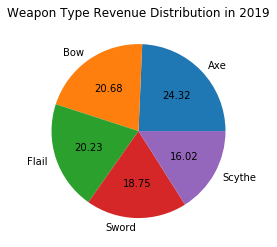

In [10]:

plt.title("Weapon Type Revenue Distribution in 2019")
plt.pie(res1['WCount'], labels = res1['WeaponTypeName'], autopct = "%.2f")
plt.show()

In [14]:
res2 = spark.sql("SELECT MONTH(th.TransactionDate) AS Month, COUNT(DISTINCT p.PlayerId) AS TotalPlayer " +
                 "FROM tableWeaponType a " +
                 "JOIN tableWeapon b ON a.WeaponTypeId = b.WeaponTypeId " +
                 "JOIN tableTransactionDetail td ON b.WeaponId = td.WeaponId " +
                 "JOIN tableTransactionHeader th ON td.TransactionId = th.TransactionId " +
                 "JOIN tablePlayer p ON th.PlayerId = p.PlayerId " +
                 "WHERE WeaponTypeName = 'Axe' " +
                 "GROUP BY MONTH(th.TransactionDate) " + 
                 "ORDER BY MONTH(th.TransactionDate) ASC ")

res2.show()

res2 = res2.toPandas()

+-----+-----------+
|Month|TotalPlayer|
+-----+-----------+
|    1|          8|
|    2|          7|
|    3|          5|
|    4|          6|
|    5|          4|
|    6|          5|
|    7|          4|
|    8|          3|
|    9|          1|
|   10|          6|
|   12|          5|
+-----+-----------+



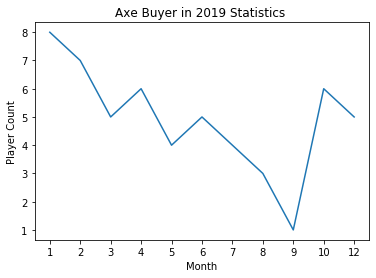

In [15]:
plt.plot(res2['TotalPlayer'])
plt.xticks(range(len(res2['Month'])), res2['Month'])
plt.title("Axe Buyer in 2019 Statistics ")
plt.xlabel('Month')
plt.ylabel('Player Count')
plt.show()

In [16]:
res3 = spark.sql("SELECT SpecWeapon, COUNT(SpecWeapon) AS Frequency FROM (SELECT CASE WHEN SUM(d.WeaponPrice*c.Quantity) >= 1000000 AND SUM(d.WeaponPrice*c.Quantity) < 1500000 THEN 'Storm Breaker' " + 
                 "WHEN SUM(d.WeaponPrice*c.Quantity) >= 1500000 AND SUM(d.WeaponPrice*c.Quantity) < 2000000 THEN 'Nightfall' ELSE 'Extinction' END AS SpecWeapon, " + 
                 "MONTH(a.TransactionDate) AS Month, b.PlayerName, SUM(d.WeaponPrice*c.Quantity) AS Spending FROM tableTransactionHeader a JOIN tablePlayer b ON a.PlayerId = b.PlayerId " +
                 "JOIN tableTransactionDetail c ON a.TransactionId = c.TransactionId " + 
                 "JOIN tableWeapon d ON c.WeaponId = d.WeaponId " +
                 "WHERE b.PlayerGender = 'Female' " +
                 "GROUP BY MONTH(a.TransactionDate),b.PlayerName " +
                 "HAVING Spending >= 1000000) AS view1 " + 
                 "GROUP BY SpecWeapon")

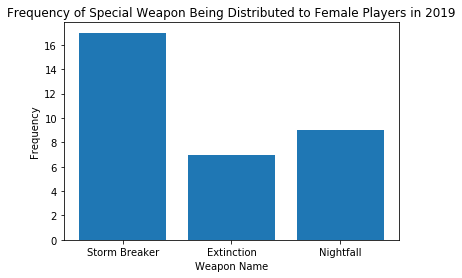

In [17]:
res3 = res3.toPandas()

plt.bar(res3['SpecWeapon'], res3['Frequency'])
plt.title("Frequency of Special Weapon Being Distributed to Female Players in 2019")
plt.xlabel("Weapon Name")
plt.ylabel("Frequency")
plt.show()

In [29]:
res4 = spark.sql("SELECT Month, COUNT(TotalPlayer) AS Total FROM(SELECT MONTH(th.TransactionDate) AS Month, COUNT(DISTINCT p.PlayerId) AS TotalPlayer " +
                 "FROM tableWeaponType a " +
                 "JOIN tableWeapon b ON a.WeaponTypeId = b.WeaponTypeId " +
                 "JOIN tableTransactionDetail td ON b.WeaponId = td.WeaponId " +
                 "JOIN tableTransactionHeader th ON td.TransactionId = th.TransactionId " +
                 "JOIN tablePlayer p ON th.PlayerId = p.PlayerId " +
                 "GROUP BY Month, p.PlayerId " +
                 "HAVING COUNT(DISTINCT a.WeaponTypeName) > 2 " +
                 "ORDER BY Month ASC ) AS a1 " +
                 "GROUP BY Month ")

res4.show()

res4 = res4.toPandas()

+-----+-----+
|Month|Total|
+-----+-----+
|    1|    6|
|    2|    5|
|    3|    4|
|    4|    3|
|    5|    3|
|    6|    3|
|    7|    5|
|    8|    2|
|    9|    1|
|   10|    5|
|   11|    2|
|   12|    5|
+-----+-----+



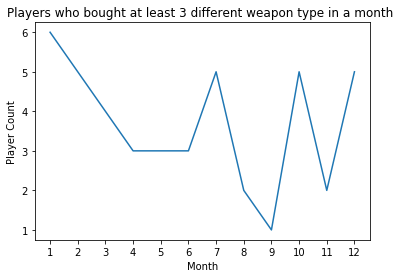

In [30]:
plt.plot(res4['Total'])
plt.xticks(range(len(res4['Month'])), res4['Month'])
plt.title("Players who bought at least 3 different weapon type in a month ")
plt.xlabel('Month')
plt.ylabel('Player Count')
plt.show()